# TS8: Filtrado No Lineal

En la TS7 se experimentaron técnicas de filtrado lineal para la mitigación de interferencias en la señal electrocardiográfica (ECG). Tal vez la interferencia que más exigió el diseño de los filtros digitales ha sido el movimiento de línea de base del ECG. La misma se trata de oscilaciones de muy baja frecuencia (< 0.5 Hz) y en ocasiones de alta energía. En esta tarea semanal se analizarán técnicas no lineales de estimación/substracción de la señal de movimiento de base $b(n)$.

$$
\hat{x} = s - \hat{b}
$$

Siendo $s$ la señal de ECG registrada con interferencias, y $\hat{x}$ la señal filtrada, una estimación del ECG sin interferencias.

Se pide que se implementen ambas estimaciones de $\hat{b}$ detalladas a continuación:

---

## 1) Filtro de mediana

Se estima $\hat{b}$ a partir de la siguiente expresión:

$$
\hat{b} = \text{med}_{600} \left( \text{med}_{200}(s) \right)
$$

Siendo $\text{med}_t(s)$ el operador de mediana de $t$ milisegundos que se aplica sobre la señal $s$, es decir:

$$
\hat{b}[n] = \text{med}(m[n], m[n-1], \dots, m[n - 600 \cdot fs])
$$

donde:

$$
m[n] = \text{med}(s[n], s[n-1], \dots, s[n - 200 \cdot fs])
$$

**Ayuda**: Puede utilizar la implementación del filtro de mediana provista en `scipy.signal`.

---

## 2) Interpolación mediante splines cúbicos

A partir de las detecciones provistas en `ecg.mat` (campo `qrs_detections`), puede estimar el nivel isoeléctrico, es decir, el momento donde la actividad eléctrica cardíaca es aproximadamente nula. El intervalo entre la onda P y Q es el momento más adecuado para estimar las características de la interferencia que originan el movimiento de la línea de base. En ese momento, el impulso cardíaco es demorado al atravesar el nódulo aurículo-ventricular.

Para la localización del segmento PQ puede valerse de la localización de cada latido (líneas rojas verticales $n_i$) y, a partir de la misma, anticipar un tiempo adecuado $n_0$ de manera tal de no incluir la onda P ni Q. Esto resultará en un conjunto de valores:

$$
S = \{ (m_i, s(m_i)) \mid i = 1, 2, \dots, Q \}
$$

donde $m_i = n_i - n_0$ y $Q$ es la cantidad de latidos en el registro (1903).

Recuerde que la señal de línea de base debe estar muestreada a la misma frecuencia que el ECG, por lo que debería remuestrear dicha señal (puede usar la función de interpolación spline para ello):

$$
\hat{b}(n) = \text{spline3}(S, n), \quad n = 1, 2, \dots, N
$$

donde la función `spline3` será la responsable de realizar la interpolación para las $N$ muestras de la señal $s$.

---

## 3) Filtro adaptado (matched filter)

Aplique el concepto de filtro adaptado para diseñar un detector de latidos. Utilice el patrón provisto en el campo `qrs_pattern1`.

**Ayuda**: Revise el concepto de filtro adaptado en Wikipedia o en la bibliografía de la materia (Porat, sección 14.4.9).

### a) Explicar conceptualmente

Explique conceptualmente cómo podría realizar un detector de latidos con la señal resultante del filtro adaptado. Discuta la utilidad y limitaciones de este método.

### b) Implementar la detección

Realice la detección de los latidos, comparando las detecciones obtenidas con las que se incluyen en la variable `qrs_detections`. Proponga alguna métrica (por ejemplo: **sensibilidad**, **valor predictivo positivo**) para cuantificar la performance del detector.


In [100]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
from pytc2.sistemas_lineales import plot_plantilla
from scipy import signal as sig
import scipy.io as sio

In [101]:
from utils_info import print_info_senal
fs = 1000  # Hz
mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_lead = mat_struct['ecg_lead'].flatten()
ecg_lead = (ecg_lead - ecg_lead.mean())/ ecg_lead.std() 
N = ecg_lead.shape[0]
print_info_senal('ECG', ecg_lead, fs)

------ECG------
Cantidad de muestras:  1129116
Frecuencia de muestreo: 1000 Hz
Duracion de la señal: 1129.116 seg
Df: 0.001 Hz
Potencia:  1.0



## Filtrado NO lineal.
- Sirve principalmente para remover ruido correlado. Es decir, cuando el ruido esta metido en la banda util, y a trravez de un FIR no lo podemos eliminar

Ambas tecncias de filtrados constan de lo mismo, estimar los movimientos de linea de base para despues restarlos

### Filtrado de mediana

El filtrado de mediana es una operación **no lineal** que se utiliza para estimar el nivel fisioléctrico de base de la señal ECG, sin verse afectado por los complejos QRS.

La mediana es básicamente un **percentil 50**, es decir, toma el valor central de una ventana deslizante de tamaño $M$. A diferencia de un promedio, no se ve afectada por valores extremos, lo cual la hace útil para separar componentes lentas de la señal.

La **clave de este filtrado** es que el tamaño de la ventana debe ser **mayor al ancho del complejo QRS**, así no lo incluye en el cálculo y queda preservado. Por eso:

- Primero se aplica un filtro con ventana de **200 ms** para suavizar la señal.  
- Luego, otra pasada con una ventana de **600 ms**, que captura mejor la línea de base lenta.  
- Finalmente, se estima la señal libre de la línea base restando:  
  `ecg_lead_est_med = ecg_lead - ecg_lead_med2`


In [102]:
from scipy.signal import medfilt

''' 1°: Filtrado de mediana con ventana de 200 milisegundos '''
M1 = int(0.2 * fs)  
ecg_lead_med1 = medfilt(ecg_lead, kernel_size=M1 | 1) # correccion :) 

''' 2°: Filtrado de mediana con ventana de 600 milisegundos '''
M2 = int(0.6 * fs)
ecg_lead_med2 = medfilt(ecg_lead_med1, kernel_size=M2 | 1)
ecg_lead_est_med = ecg_lead - ecg_lead_med2

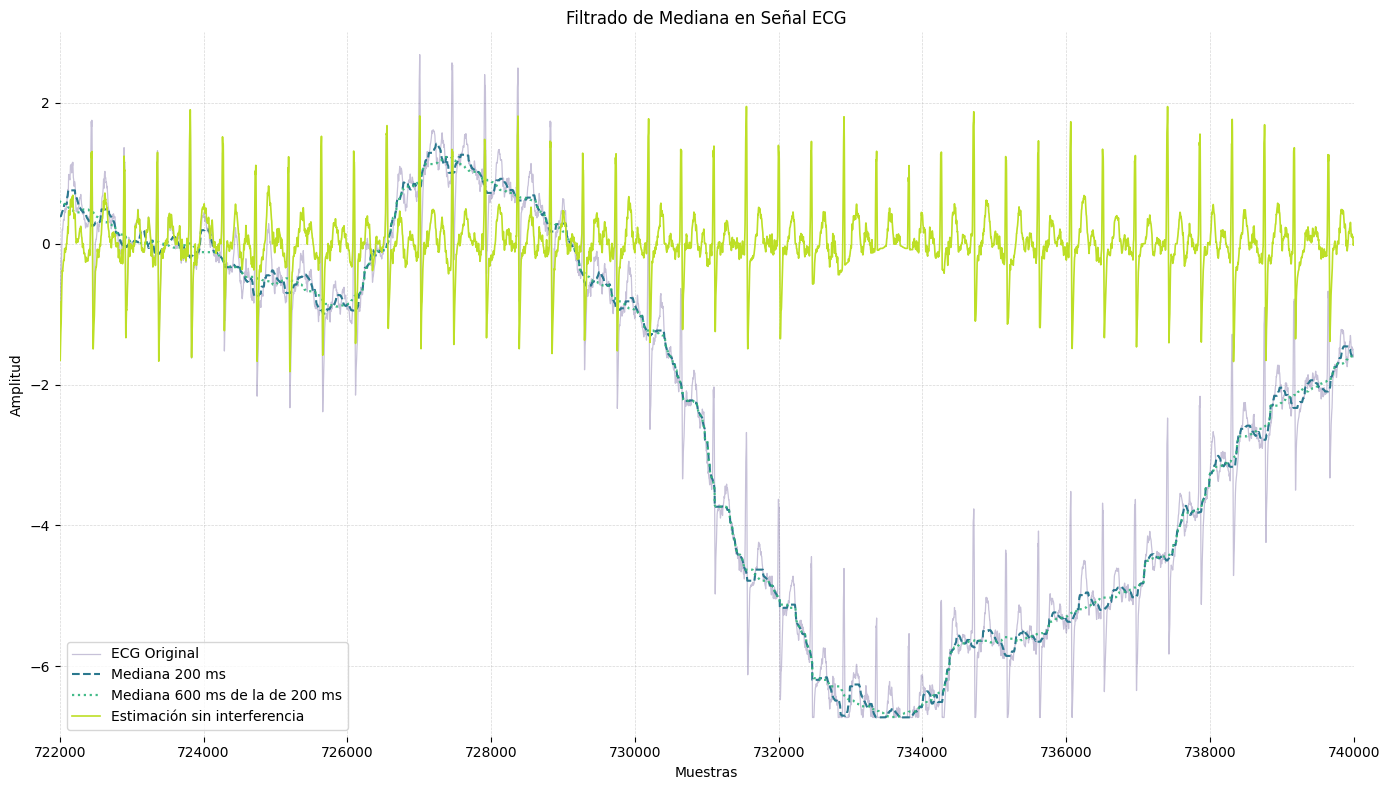

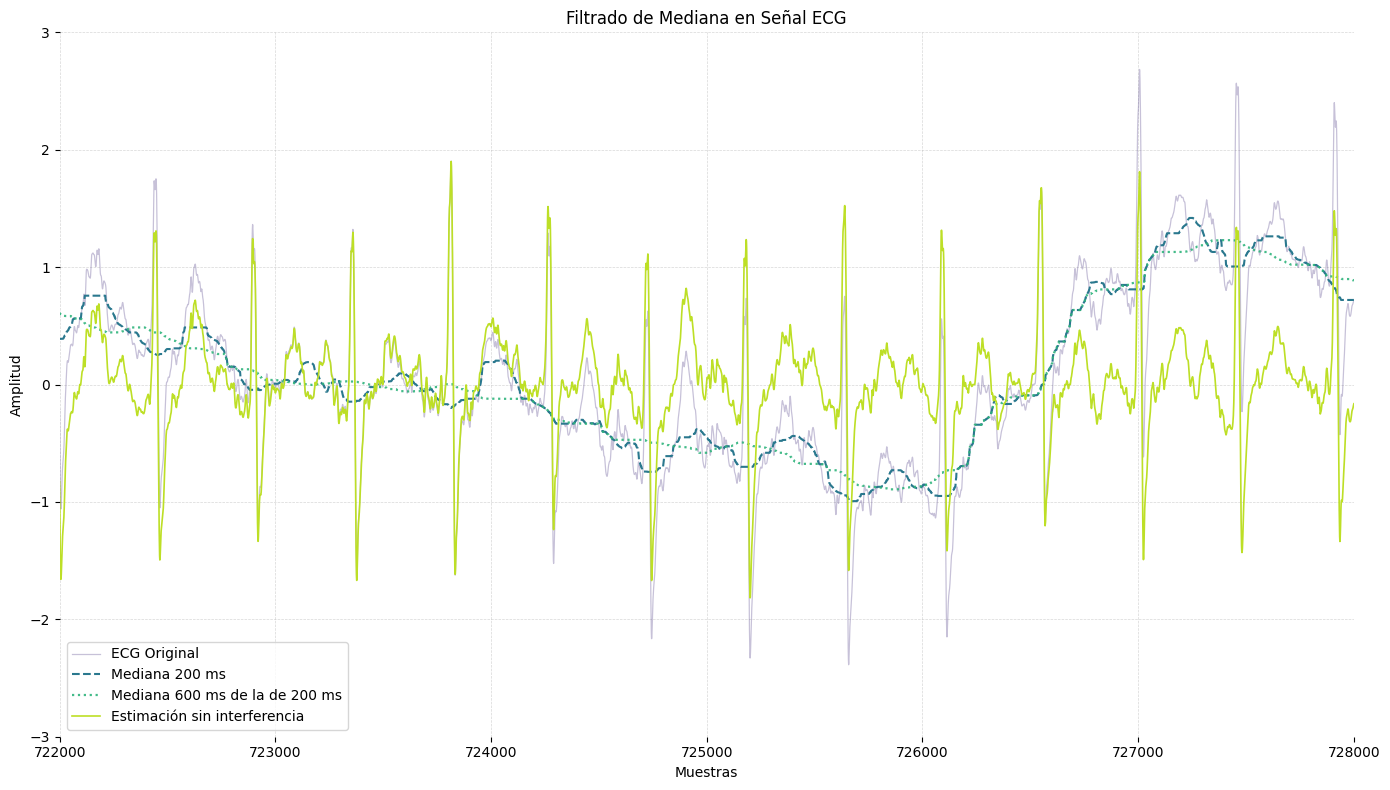

In [103]:
import matplotlib.pyplot as plt
from matplotlib import colormaps


plt.style.use("seaborn-v0_8-muted")


cmap = colormaps['viridis']
col1 = cmap(0.15)
col2 = cmap(0.4)
col3 = cmap(0.65)
col4 = cmap(0.9)

plt.figure(figsize=(14, 8))
plt.plot(ecg_lead, label='ECG Original', lw=0.9, c=col1, alpha=0.3)
plt.plot(ecg_lead_med1, label='Mediana 200 ms', lw=1.5, ls='--', c=col2)
plt.plot(ecg_lead_med2, label='Mediana 600 ms de la de 200 ms', lw=1.6, ls=':', c=col3, alpha=0.9)
plt.plot(ecg_lead_est_med, label='Estimación sin interferencia', lw=1.2, c=col4)

plt.xlim(722000, 740000)
plt.ylim(-7, 3)
plt.title('Filtrado de Mediana en Señal ECG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xticks()
plt.yticks()
plt.legend(loc='lower left', fontsize=10, framealpha=0.8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.02)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(ecg_lead, label='ECG Original', lw=0.9, c=col1, alpha=0.3)
plt.plot(ecg_lead_med1, label='Mediana 200 ms', lw=1.5, ls='--', c=col2)
plt.plot(ecg_lead_med2, label='Mediana 600 ms de la de 200 ms', lw=1.6, ls=':', c=col3, alpha=0.9)
plt.plot(ecg_lead_est_med, label='Estimación sin interferencia', lw=1.2, c=col4)

plt.xlim(722000, 728000)
plt.ylim(-3, 3)
plt.title('Filtrado de Mediana en Señal ECG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xticks()
plt.yticks()
plt.legend(loc='lower left', fontsize=10, framealpha=0.8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.02)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

### Metodo de Cubic Splines

### Estimación de la línea de base con interpolación spline

Se usaron las detecciones de QRS (`qrs_detections`) para estimar el nivel isoeléctrico.  
A cada latido $n_i$ se le restaron 85 ms para obtener el punto $m_i$ dentro del segmento PQ:

$$
m_i = n_i - n_0 \quad \text{con} \quad n_0 = 0.085 \cdot f_s
$$

Con esos puntos se armó el conjunto:

$$
S = \{(m_i, s(m_i))\}
$$

Después se aplicó interpolación spline cúbica para estimar la línea de base $\hat{b}(n)$ en toda la señal:

$$
\hat{b}(n) = \text{spline3}(S, n)
$$

Y se obtuvo la señal corregida:

$$
\hat{s}(n) = s(n) - \hat{b}(n)
$$

Se eligió $n_0 = 85$ ms como desplazamiento hacia atrás desde cada latido porque ese valor cae dentro del segmento PQ,  es decir, **después de la onda P pero antes del inicio del complejo QRS**.  Esto asegura que el punto $m_i = n_i - n_0$ esté en una zona donde la actividad eléctrica cardíaca es mínima,  lo cual es ideal para estimar la línea de base.

El valor fue elegido considerando que el segmento PQ suele durar entre 80 y 120 ms,  y que el complejo QRS comienza inmediatamente después. Elegir 85 ms permite evitar incluir la onda P.


In [104]:
qrs_detections = mat_struct['qrs_detections'].flatten()

n0 = int(0.085 * fs)  # 85 ms
indice_seg_isoelectrico = qrs_detections - n0
indice_seg_isoelectrico = indice_seg_isoelectrico[indice_seg_isoelectrico > 0]
indice_seg_isoelectrico = indice_seg_isoelectrico[indice_seg_isoelectrico < N]
seg_isoelectrico = ecg_lead[indice_seg_isoelectrico]


from scipy.interpolate import CubicSpline

spline_func = CubicSpline(indice_seg_isoelectrico, seg_isoelectrico)
b_hat_spline = spline_func(np.arange(N))

ecg_lead_est_spline = ecg_lead - b_hat_spline

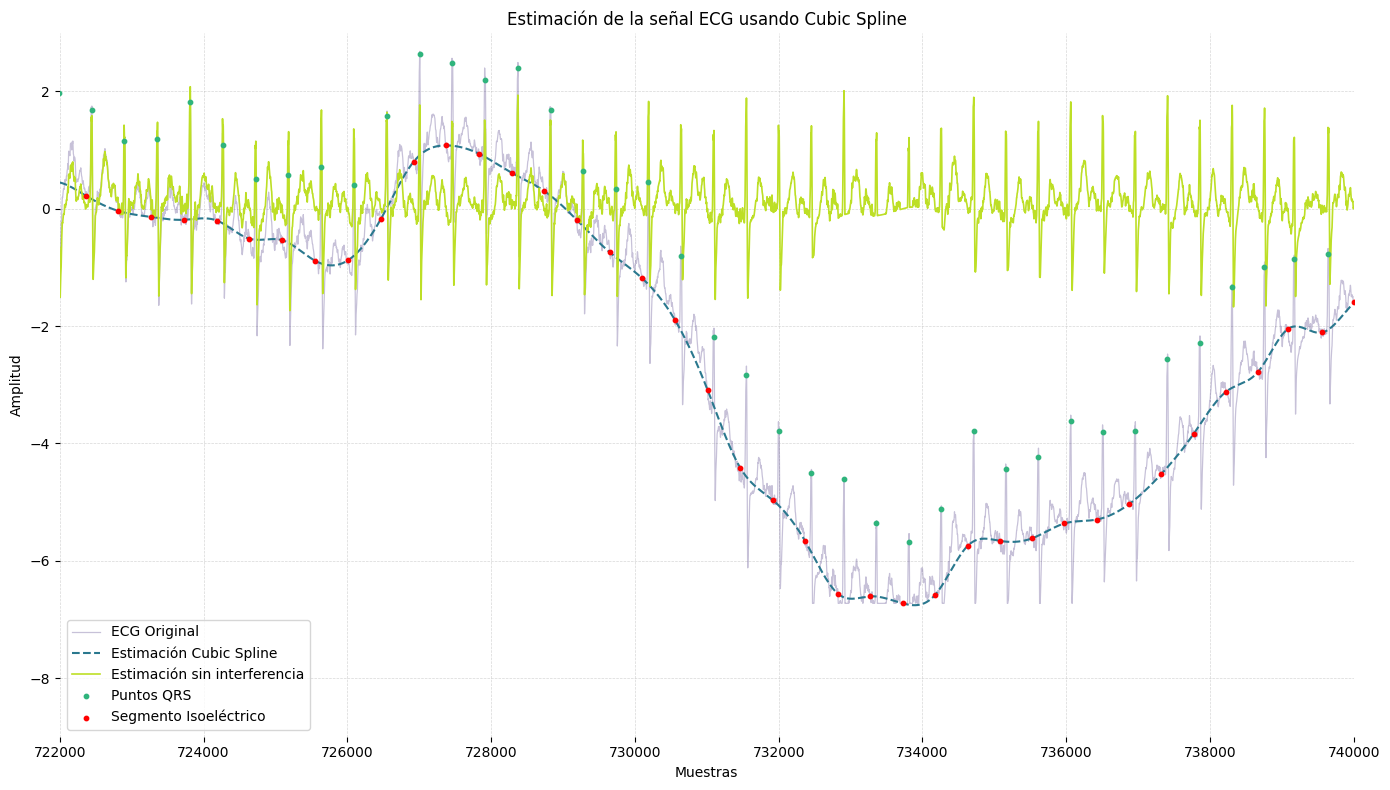

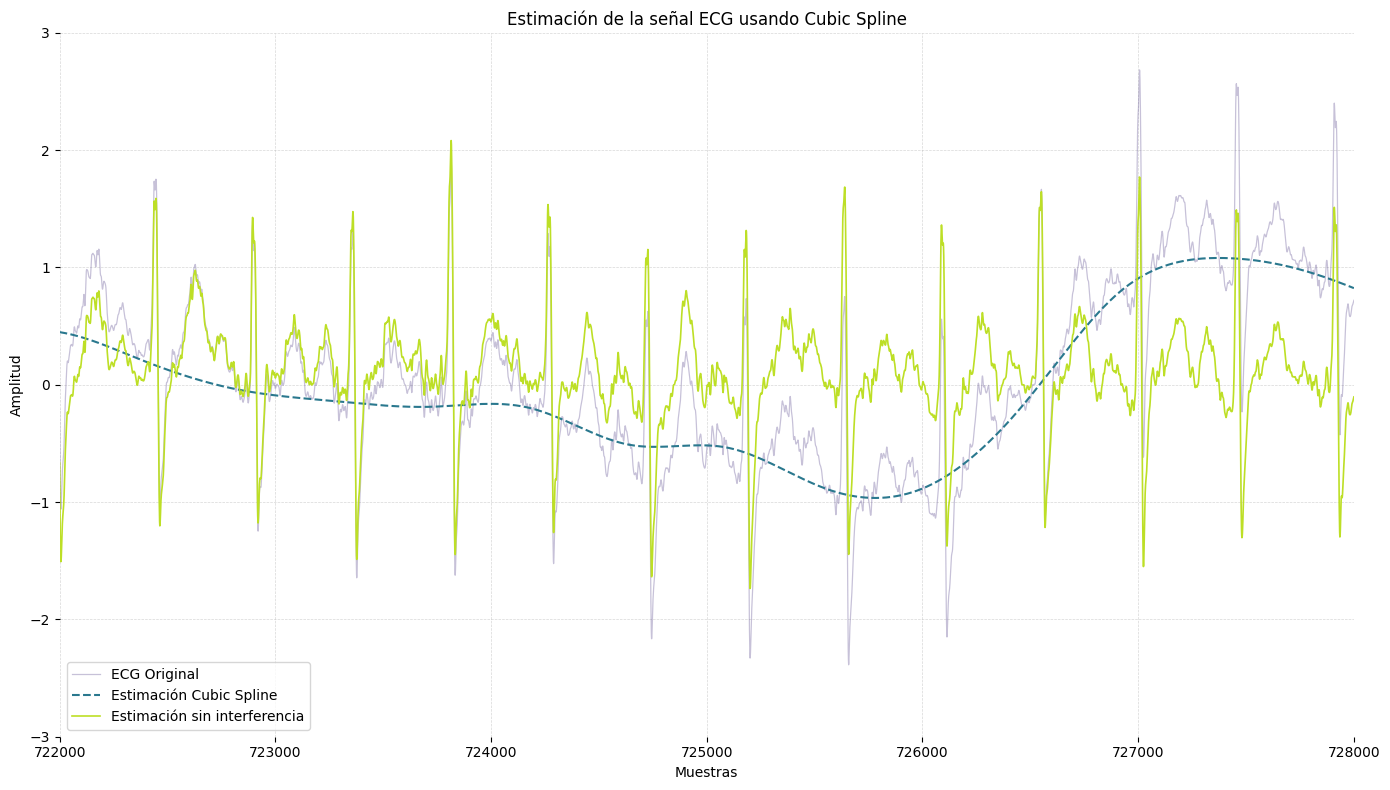

In [105]:
plt.figure(figsize=(14, 8))
plt.plot(ecg_lead, label='ECG Original', lw=0.9, c=col1, alpha=0.3)
plt.plot(b_hat_spline, label='Estimación Cubic Spline', lw=1.5, ls='--', c=col2)
plt.plot(ecg_lead_est_spline, label='Estimación sin interferencia', lw=1.2, c=col4)
plt.scatter(qrs_detections, ecg_lead[qrs_detections], color=col3, label='Puntos QRS', s=10, zorder=5)
plt.scatter(indice_seg_isoelectrico, seg_isoelectrico, color='red', label='Segmento Isoeléctrico', s=10, zorder=5)
plt.xlim(722000, 740000)
plt.ylim(-9, 3)
plt.title('Estimación de la señal ECG usando Cubic Spline')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xticks()
plt.yticks()
plt.legend(loc='lower left', fontsize=10, framealpha=0.8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 8))
plt.plot(ecg_lead, label='ECG Original', lw=0.9, c=col1, alpha=0.3)
plt.plot(b_hat_spline, label='Estimación Cubic Spline', lw=1.5, ls='--', c=col2)
plt.plot(ecg_lead_est_spline, label='Estimación sin interferencia', lw=1.2, c=col4)
#plt.scatter(qrs_detections, ecg_lead[qrs_detections], color=col3, label='Puntos QRS', s=10, zorder=5)
#plt.scatter(indice_seg_isoelectrico, seg_isoelectrico, color='red', label='Segmento Isoeléctrico', s=10, zorder=5)
plt.xlim(722000, 728000)
plt.ylim(-3, 3)
plt.title('Estimación de la señal ECG usando Cubic Spline')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xticks()
plt.yticks()
plt.legend(loc='lower left', fontsize=10, framealpha=0.8)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()

### Matched Filter: Para detectar complejos qrs



Para detectar los latidos, apliqué el concepto de **filtro adaptado (matched filter)**. Este tipo de filtro se utiliza cuando se quiere detectar una señal conocida dentro de una señal más larga y ruidosa. En este caso, la señal conocida es un **patrón de complejo QRS típico**, provisto en el archivo `ecg.mat` bajo el nombre `qrs_pattern1`.

La idea es **correlacionar** ese patrón con la señal de ECG corregida (`ecg_lead_est_spline`), y de esa forma obtener una señal de salida (`ecg_corr`) donde los picos marcan los lugares donde la forma del QRS aparece con mayor similitud. La correlación actúa como un detector que responde fuerte cuando la señal actual se parece al patrón.

Para realizar la detección de los latidos:
- Normalicé el patrón QRS para que tenga media cero y desviación estándar uno.
- Correlacioné ese patrón con la señal de ECG.
- Luego normalicé la señal de correlación.
- Finalmente, utilicé `find_peaks` para identificar los máximos locales por encima de un umbral (10% del valor máximo), y separarlos al menos 100 ms entre sí.


#### limitaciones con las que me cruce:

- Puede generar **falsos positivos** si otras partes de la señal tienen una forma similar al QRS. (Spoiler: Pasa)


In [106]:
''' Cargo complejo QRS'''
qrs_pattern = mat_struct['qrs_pattern1'].flatten()
qrs_pattern = (qrs_pattern - qrs_pattern.mean()) / qrs_pattern.std()

''' Correlaciono '''
from scipy.signal import correlate
ecg_corr = correlate(ecg_lead_est_spline, qrs_pattern, mode='same')
ecg_corr = ecg_corr - np.mean(ecg_corr) 
ecg_corr = ecg_corr / np.std(ecg_corr)

'''Deteción de picos'''
from scipy.signal import find_peaks
peaks, _ = find_peaks(ecg_corr, height=np.max(ecg_corr) * 0.1, distance=int(fs * 0.1))


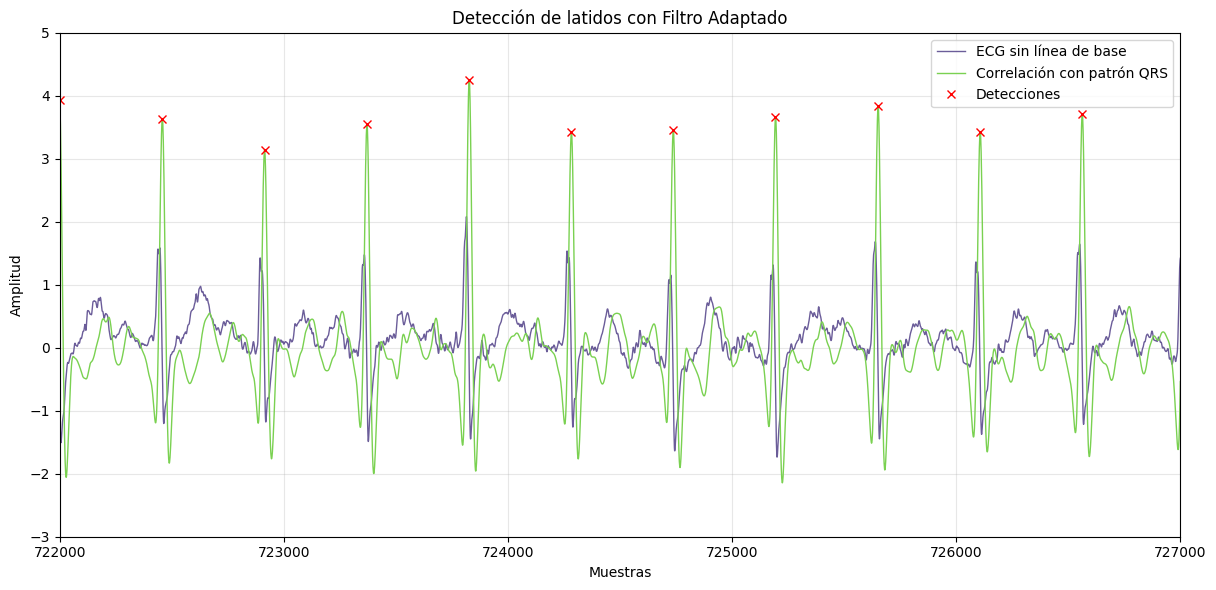

In [107]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

plt.style.use("seaborn-v0_8-muted")
cmap = colormaps['viridis']
col1 = cmap(0.15)  # ECG sin línea base
col2 = cmap(0.8)   # correlación

plt.figure(figsize=(12, 6))
plt.plot(ecg_lead_est_spline, label='ECG sin línea de base', lw=1.0, c=col1, alpha=0.8)
plt.plot(ecg_corr, label='Correlación con patrón QRS', lw=1.0, c=col2)
plt.plot(peaks, ecg_corr[peaks], 'rx', label='Detecciones')

plt.title("Detección de latidos con Filtro Adaptado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.xlim(722000, 727000)
plt.ylim(-3, 5)
plt.show()



#### Evaluación de la detección de picos

A partir de los puntos reales (`qrs_detections`), defino intervalos de ±50 ms.  
La idea es ver si los picos detectados por el filtro adaptado caen dentro de esos intervalos.  
Si cae, es un acierto. Si no, falso positivo.  
También se puede ver cuántos reales no fueron detectados (falsos negativos).

Con eso armo la matriz de confusión y saco métricas.


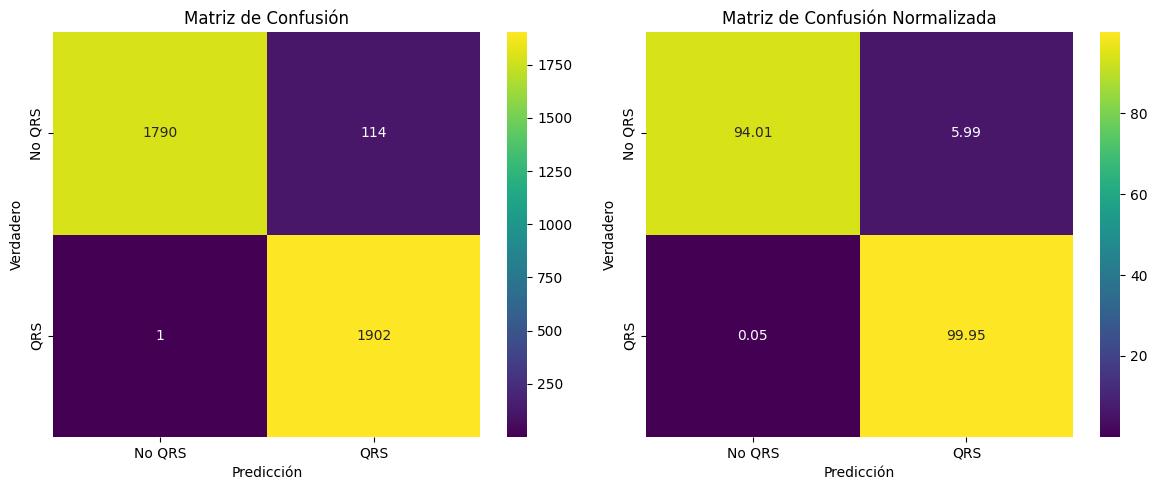

In [108]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

tolerancia_muestras = int(0.05 * fs)

'''intervalos de eventos (+- 50ms alrededor de cada QRS)'''
eventos = []
for qrs in qrs_detections:
    ini = max(0, qrs - tolerancia_muestras)
    fin = min(len(ecg_lead_est_spline), qrs + tolerancia_muestras + 1)
    eventos.append((ini, fin))

'''intervalos de NO EVENTO: todo lo que no este en eventos'''
no_eventos = []
inicio = 0
for (ini, fin) in eventos:
    if inicio < ini:
        no_eventos.append((inicio, ini))
    inicio = fin
if inicio < len(ecg_lead_est_spline):
    no_eventos.append((inicio, len(ecg_lead_est_spline)))

'''Evaluación de la detección de picos'''
TP = 0
FN = 0
for ini, fin in eventos:
    if np.any((peaks >= ini) & (peaks < fin)):
        TP += 1
    else:
        FN += 1

''' Evaluación de los no eventos '''
TN = 0
FP = 0
for ini, fin in no_eventos:
    if np.any((peaks >= ini) & (peaks < fin)):
        FP += 1
    else:
        TN += 1


y_true = [1]*TP + [1]*FN + [0]*FP + [0]*TN
y_pred = [1]*TP + [0]*FN + [1]*FP + [0]*TN

cm = confusion_matrix(y_true, y_pred)


labels = ["No QRS", "QRS"]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")

plt.subplot(1,2,2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels)
sns.heatmap(100 * cm / cm.sum(axis=1, keepdims=True), annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión Normalizada")
plt.tight_layout()
plt.show()

Hice lo siguiente:

Considero evento Real al intervalo (qrs_detections - 50ms ; qrs_detections + 50ms) , todo el resto de la señal lo considero NO evento. 
como se ve en la matriz de confusion el 100% (en realidad es es 100% redondeado, de los 1903 complejos, 1902 fueron detectados) de los complejos qrs fueron detectados. Sin embargo del 100% de los fragmentos de la señal que NO 
son qrs, un 6% (114 segmentos) fue erroneamente identificado como qrs cuando no lo es. 

### Mas Métricas de Evaluación

Ademas, se utilizaron las siguientes métricas para evaluar la calidad de la detección de eventos (latidos).

- **Accuracy (Exactitud):**  
  Mide la proporción total de decisiones correctas (verdaderos positivos y verdaderos negativos) sobre el total de evaluaciones realizadas.  
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Precision (Valor Predictivo Positivo):**  
  Mide qué proporción de las detecciones positivas fueron realmente verdaderas. 
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall (Sensibilidad):**  
  Mide qué proporción de los eventos reales fueron correctamente detectados. 
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

  


In [109]:

accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy:.2f}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
print(f"Precision: {precision:.2f}")

recall = TP / (TP + FN) if (TP + FN) > 0 else 0
print(f"Recall: {recall:.2f}")



Accuracy: 0.97
Precision: 0.94
Recall: 1.00


### Conclusiones Finales
Los filtros no lineales resultaron muy útiles para remover interferencias de baja frecuencia dentro de la banda de interés, algo que los filtros lineales no podían resolver bien.
Tanto el método de splines cúbicos como el de filtrado de mediana funcionaron bien para estimar la línea de base. Sin embargo, el método de splines requiere conocer las posiciones de los QRS para poder ubicar el segmento PQ, mientras que el filtro de mediana es mucho más sencillo y no necesita tanta información previa.

Por otro lado, el matched filter funcionó bastante bien: detectó casi todos los latidos (falló solo uno), aunque tuvo el problema de falsos positivos. Eso muestra que si bien es sensible, no es del todo específico.

### Bonus 

💎 ¿Podría funcionar el detector basado en el filtro adaptado con un latido perteneciente a otro registro o paciente?

No creo. El filtro adaptado calcula la correlación entre un latido “modelo” y la señal. Si ese modelo es de otra persona, lo más probable es que la forma del latido no coincida bien, así que la correlación va a ser baja y el detector no va a funcionar bien.
Capaz para algo más general, donde haya más variabilidad entre latidos, conviene usar otro tipo de detector, como uno basado en transformadas de onditas, que son más robustas a cambios en la forma.

💎 Proponga alguna mejora a los estimadores de la señal  b, como por ejemplo usar las técnicas multirate. 
Una opción es usar técnicas multirate. Por ejemplo, podés diezmar la señal, estimar la línea de base $b$ sobre esa versión diezmada (donde los QRS están más "aplastados") y después interpolar la estimación para volver al tamaño original. Al reducir la cantidad de muestras, el cálculo es más eficiente y se evita que el QRS "ensucie" tanto la estimación.
Después podés usar interpolación tipo CubicSpline para volver a la frecuencia original y restárselo al ECG original.